# Compare with jaxoplanet

Since ``squishyplanet`` takes a more numerical approach to generating transit lightcurves than elegant packages such as ``exoplanet`` and ``starry``, it had to trade either speed or accuracy in exchange for the ability to model more complex planet shapes. We've opted to sacrifice the former to preserve the latter. So, in the limiting case where `squishyplanet` models a truly spherical planet, we want to make sure that it agrees with previous implementations of the polynomial limb darkening model.

Here we'll compare the performace of ``squishyplanet`` with [jaxoplanet](https://jax.exoplanet.codes/en/latest/), a JAX-based implementation of the [exoplanet](https://docs.exoplanet.codes/en/latest/) and [starry](https://starry.readthedocs.io/en/latest/) packages.

In [1]:
# JAX imports
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

# Helpful misc imports
import matplotlib.pyplot as plt
from tqdm import tqdm

# squishyplanet imports
from squishyplanet import OblateSystem

# jaxoplanet imports
from jaxoplanet.orbits.keplerian import Central, System
from jaxoplanet.units import unit_registry as ureg
from jaxoplanet.light_curves import limb_dark_light_curve

Let's first generate a random system with quadratic limb darkening coefficients and compare the lightcurves generated by the two packages. We have to jump through a few hoops to directly compare the two since ``jaxoplanet`` uses inputs with units, while ``squishyplanet`` is scale-free (aside from time units, all distance units are in terms of $R_\odot$). Here's the ``jaxoplanet`` lightcurve:

/Users/cassese/miniconda3/envs/oblate/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UserWarning: The unit of a Quantity is stripped when downcasted to an array.
  return np.asarray(x, float)


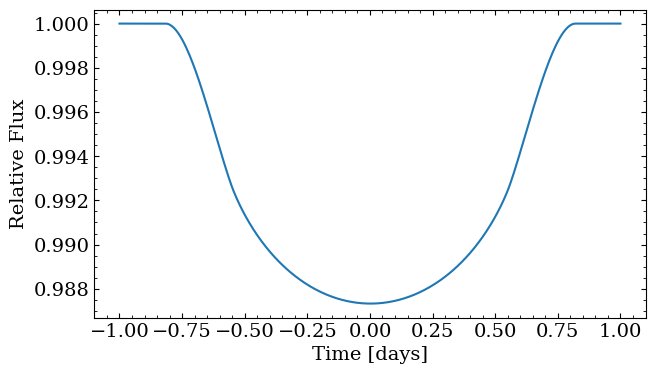

In [2]:
poly_limbdark_order = 2
times = (
    jnp.linspace(-1, 1, int(2 * 24 * 60 / 6)) * ureg.day
)  # 2 days at 10 minute cadence
key = jax.random.PRNGKey(0)
key, *subkeys = jax.random.split(key, num=8)

u = jax.random.uniform(subkeys[6], shape=(poly_limbdark_order,))
star_mass = jax.random.uniform(subkeys[0], minval=0.1, maxval=1.5) * ureg.M_sun
semimajor_axis = jax.random.uniform(subkeys[1], minval=0.005, maxval=5.0) * ureg.au
impact_param = jax.random.uniform(subkeys[2], minval=0.0, maxval=1.0)
planet_rad = jax.random.uniform(subkeys[3], minval=0.001, maxval=0.25) * ureg.R_sun
eccentricity = jax.random.uniform(subkeys[4], minval=0.0, maxval=0.9)
omega = jax.random.uniform(subkeys[5], minval=0.0, maxval=2 * jnp.pi)
Omega = jnp.pi

star = Central(radius=1 * ureg.R_sun, mass=star_mass)
planet = (
    System(star)
    .add_body(
        time_transit=0.0,
        semimajor=semimajor_axis,
        impact_param=impact_param,
        radius=planet_rad,
        eccentricity=eccentricity,
        omega_peri=omega * ureg.rad,
        asc_node=Omega * ureg.rad,
        mass=0.0,
    )
    .bodies[0]
)

jaxoplanet_lc = 1 + limb_dark_light_curve(planet, u)(times)

fig, ax = plt.subplots()
ax.plot(times, jaxoplanet_lc)
ax.set(xlabel="Time [days]", ylabel="Relative Flux");

And here's the ``squishyplanet`` lightcurve:

/Users/cassese/miniconda3/envs/oblate/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UserWarning: The unit of a Quantity is stripped when downcasted to an array.
  return np.asarray(x, float)


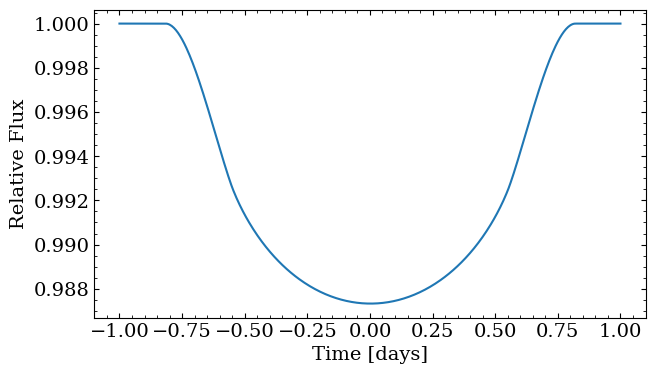

In [3]:
# squishyplanet expects angles between 0 and 2pi
Omega = jnp.arctan2(
    planet.sin_asc_node.to(ureg.radian).magnitude,
    planet.cos_asc_node.to(ureg.radian).magnitude,
)
Omega = jnp.where(Omega < 0, Omega + 2 * jnp.pi, Omega)

omega = jnp.arctan2(
    planet.sin_omega_peri.to(ureg.radian).magnitude,
    planet.cos_omega_peri.to(ureg.radian).magnitude,
)
omega = jnp.where(omega < 0, omega + 2 * jnp.pi, omega)

state = {
    "t_peri": planet.time_peri.to(ureg.day).magnitude,
    "times": times.to(ureg.day).magnitude,
    "period": planet.period.to(ureg.day).magnitude,
    "a": planet.semimajor.to(ureg.R_sun).magnitude,
    "e": planet.eccentricity.to(ureg.dimensionless).magnitude,
    "i": planet.inclination.to(ureg.radian).magnitude,
    "Omega": Omega,
    "omega": omega,
    "f1": 0.0,  # this is a perfectly spherical planet for comparison, so f1 = f2 = 0
    "f2": 0.0,
    "r": planet.radius.to(ureg.R_sun).magnitude,
    "obliq": 0.0,
    "prec": 0.0,
    "ld_u_coeffs": jnp.array(u),
    "tidally_locked": False,
}

s = OblateSystem(**state)

squishyplanet_lc = s.lightcurve()

fig, ax = plt.subplots()
ax.plot(times, squishyplanet_lc)
ax.set(xlabel="Time [days]", ylabel="Relative Flux");

They qualitatively seem very similar. To access the accuracy of each, let's use ``jaxoplanet`` to compute a high-precision lightcurve that uses a higher order numerical integrator than the default settings to compare the two.

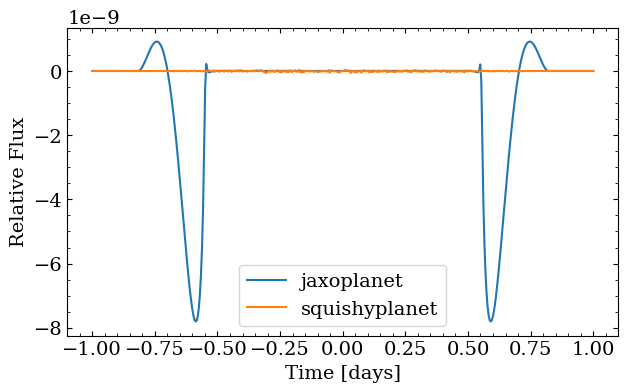

In [4]:
comparison_lc = 1 + limb_dark_light_curve(planet, u, order=100)(times)

fig, ax = plt.subplots()
ax.plot(times.magnitude, jaxoplanet_lc - comparison_lc, label="jaxoplanet")
ax.plot(times.magnitude, squishyplanet_lc - comparison_lc, label="squishyplanet")
ax.set(xlabel="Time [days]", ylabel="Relative Flux")
ax.legend()

For this random set of parameters at least, both agree with the high-precision lightcurve to within a few parts per billion, meaning they are effectively equivalent for all real-world purposes. Even the highest-quality photometry is typically only accurate to a few parts per million, so although technically here ``squishyplanet``'s default settings produced a more "accurate" lightcurve than ``jaxoplanet``'s, it really doesn't matter once you're at this level of precision.

Here is how ``squishyplanet`` compares to ``jaxoplanet`` as you increase the ``order`` term in ``jaxoplanet``'s numerical integrator:

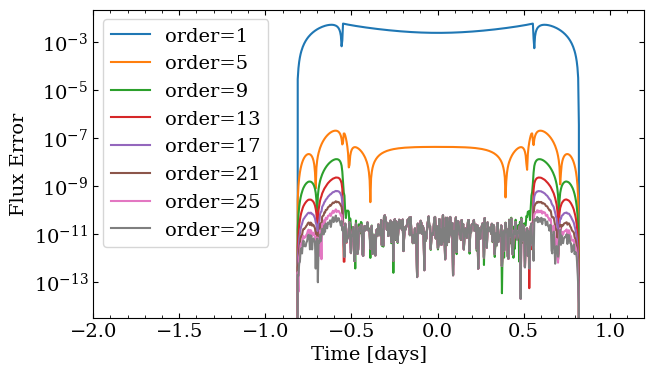

In [5]:
fig, ax = plt.subplots()
for order in jnp.arange(1, 30, 4):
    j = 1 + limb_dark_light_curve(planet, u, order=int(order))(times)
    ax.plot(times.magnitude, jnp.abs(j - squishyplanet_lc), label=f"order={order}")
ax.set(xlabel="Time [days]", ylabel="Flux Error", yscale="log", xlim=(-2, 1.2))
ax.legend()

It looks like around ``order``=20, the difference spikes during ingress and egress reach the same magnitude as ``squishyplanet``'s typical error.

In general, ``squishyplanet`` will be slower than ``jaxoplanet`` due to a higher reliance on numerical integrals. The difference isn't huge for a relatively sparse, low-cadence time series like this, but can grow quite large for dense observations. Consider the simple timing experiment:

In [6]:
%timeit limb_dark_light_curve(planet, u)(times).block_until_ready()
%timeit s.lightcurve().block_until_ready()

7.36 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now we can compute a more ambitious time series:

In [7]:
times = jnp.linspace(-1, 1, 17280) * ureg.day  # 10s cadence for 48 hours
_ = limb_dark_light_curve(planet, u)(times) # let jax compile the function
state["times"] = times.to(ureg.day).magnitude
s = OblateSystem(**state)
_ = s.lightcurve() # let jax compile the function

%timeit limb_dark_light_curve(planet, u)(times).block_until_ready()
%timeit s.lightcurve().block_until_ready()

9.58 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
451 ms ± 9.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Where ``squishyplanet`` really suffers though is in computing derivatives. Both ``squishyplanet`` and ``jaxoplanet`` are built on top of ``JAX``, meaning they can use autodifferentiation to compute gradients of the likelihood with respect to each of the input parameters. This in turn lets users fit the lightcurve to data using gradient-based optimization algorithms, most notably Hamiltonian Monte Carlo and variants of the No U-Turn Sampler. ``jaxoplanet`` does not naturally expose these gradients to the user, so it's difficult to fairly time them, but suffice to say that it can compute them quickly. ``squishyplanet`` on the other hand is quite slow at computing gradients:

In [8]:
times = (
    jnp.linspace(-1, 1, int(2 * 24 * 60 / 6)) * ureg.day
)  # back to 2 days at 10 minute cadence
state["times"] = times.to(ureg.day).magnitude
state["data"] = jnp.ones_like(
    times.magnitude
)  # dummy data for a likelihood calculation
s = OblateSystem(**state)
_ = s.loglike()

# jax.grad(s.loglike)({"a":3.0})

This last line would take a few minutes to compile, then still takes at least 100s of ms to compute each time after that. This is likely too slow to be useful for fitting to real data and is a major limitation of ``squishyplanet`` in its current form. It feels somewhat silly to go through the trouble of writing it in ``JAX`` and then not using the autodifferentiation capabilities, but for now the only ``JAX`` magic we use is compiling the function evaluation in the first place. That said, other gradient-free inference routines (such as most Nested Sampling algorithms or even likelihood-free methods) should still work fine with ``squishyplanet``.

Finally, to make sure that this randomly generated curve isn't a fluke, let's repeat the experiment with a few different random systems:

100%|██████████| 1000/1000 [00:32<00:00, 30.74it/s]


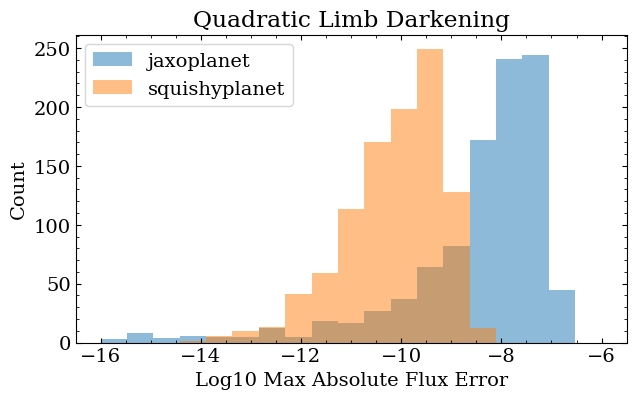

In [9]:
def light_curve_compare(key, poly_limbdark_order):
    times = (
        jnp.linspace(-1, 1, int(2 * 24 * 60 / 6)) * ureg.day
    )  # 2 days at 10 minute cadence

    key, *rand_key = jax.random.split(key, num=8)

    u = jax.random.uniform(rand_key[6], shape=(poly_limbdark_order,))
    star_mass = jax.random.uniform(rand_key[0], minval=0.1, maxval=1.5) * ureg.M_sun
    semimajor_axis = jax.random.uniform(rand_key[1], minval=0.005, maxval=5.0) * ureg.au
    impact_param = jax.random.uniform(rand_key[2], minval=0.0, maxval=1.0)
    planet_rad = jax.random.uniform(rand_key[3], minval=0.001, maxval=0.25) * ureg.R_sun
    eccentricity = jax.random.uniform(rand_key[4], minval=0.0, maxval=0.9)
    omega = jax.random.uniform(rand_key[5], minval=0.0, maxval=2 * jnp.pi)
    Omega = jnp.pi

    star = Central(radius=1 * ureg.R_sun, mass=star_mass)
    planet = (
        System(star)
        .add_body(
            time_transit=0.0,
            semimajor=semimajor_axis,
            impact_param=impact_param,
            radius=planet_rad,
            eccentricity=eccentricity,
            omega_peri=omega * ureg.rad,
            asc_node=Omega * ureg.rad,
            mass=0.0,
        )
        .bodies[0]
    )

    compare_lc = 1 + limb_dark_light_curve(planet, u, order=100)(times)
    jaxoplanet_lc = 1 + limb_dark_light_curve(planet, u)(times)

    # generate comparison light curve
    Omega = jnp.arctan2(
        planet.sin_asc_node.to(ureg.radian).magnitude,
        planet.cos_asc_node.to(ureg.radian).magnitude,
    )
    Omega = jnp.where(Omega < 0, Omega + 2 * jnp.pi, Omega)

    omega = jnp.arctan2(
        planet.sin_omega_peri.to(ureg.radian).magnitude,
        planet.cos_omega_peri.to(ureg.radian).magnitude,
    )
    omega = jnp.where(omega < 0, omega + 2 * jnp.pi, omega)

    state = {
        "t_peri": planet.time_peri.to(ureg.day).magnitude,
        "times": times.to(ureg.day).magnitude,
        "period": planet.period.to(ureg.day).magnitude,
        "a": planet.semimajor.to(ureg.R_sun).magnitude,
        "e": planet.eccentricity.to(ureg.dimensionless).magnitude,
        "i": planet.inclination.to(ureg.radian).magnitude,
        "Omega": Omega,
        "omega": omega,
        "f1": 0.0,  # always circular for testing
        "f2": 0.0,
        "r": planet.radius.to(ureg.R_sun).magnitude,
        "obliq": 0.0,
        "prec": 0.0,
        "ld_u_coeffs": jnp.array(u),
        "tidally_locked":False
    }

    s = OblateSystem(**state)
    test_lc = s.lightcurve()

    m = (jaxoplanet_lc != 0) | (test_lc != 0)
    return (
        jnp.max(jnp.abs(jaxoplanet_lc[m] - compare_lc[m])),
        jnp.max(jnp.abs(test_lc[m] - compare_lc[m])),
    )


jaxoplanet_errs = []
squishyplanet_errs = []
for i in tqdm(range(1_000)):
    jax.random.PRNGKey(i)
    j, s = light_curve_compare(jax.random.PRNGKey(i), 2)
    jaxoplanet_errs.append(j)
    squishyplanet_errs.append(s)
jaxoplanet_errs = jnp.array(jaxoplanet_errs)
squishyplanet_errs = jnp.array(squishyplanet_errs)


fig, ax = plt.subplots()
j = jnp.log10(jaxoplanet_errs)
j = jnp.where(jnp.abs(j) == jnp.inf, jnp.nan, j)
s = jnp.log10(squishyplanet_errs)
s = jnp.where(jnp.abs(s) == jnp.inf, jnp.nan, s)
ax.hist(j, bins=jnp.linspace(-16, -6, 20), alpha=0.5, label="jaxoplanet")
ax.hist(s, bins=jnp.linspace(-16, -6, 20), alpha=0.5, label="squishyplanet")
ax.set(
    xlabel="Log10 Max Absolute Flux Error",
    ylabel="Count",
    title="Quadratic Limb Darkening",
)
ax.legend();

And, to check higher-order limb darkening laws:

100%|██████████| 1000/1000 [00:58<00:00, 17.15it/s]


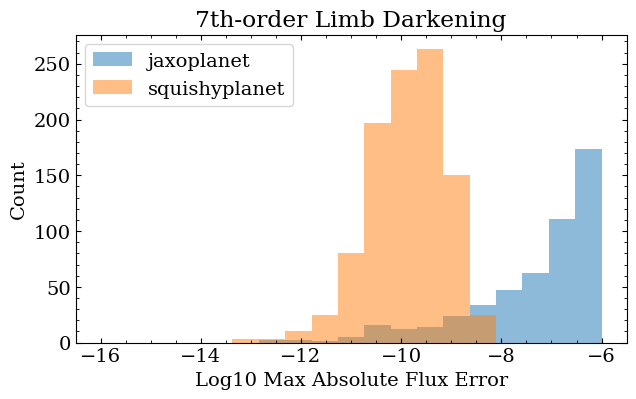

In [10]:
def light_curve_compare(key, poly_limbdark_order):
    times = (
        jnp.linspace(-1, 1, int(2 * 24 * 60 / 6)) * ureg.day
    )  # 2 days at 10 minute cadence

    key, *rand_key = jax.random.split(key, num=8)

    u = jax.random.uniform(rand_key[6], shape=(poly_limbdark_order,))
    star_mass = jax.random.uniform(rand_key[0], minval=0.1, maxval=1.5) * ureg.M_sun
    semimajor_axis = jax.random.uniform(rand_key[1], minval=0.005, maxval=5.0) * ureg.au
    impact_param = jax.random.uniform(rand_key[2], minval=0.0, maxval=1.0)
    planet_rad = jax.random.uniform(rand_key[3], minval=0.001, maxval=0.25) * ureg.R_sun
    eccentricity = jax.random.uniform(rand_key[4], minval=0.0, maxval=0.9)
    omega = jax.random.uniform(rand_key[5], minval=0.0, maxval=2 * jnp.pi)
    Omega = jnp.pi

    star = Central(radius=1 * ureg.R_sun, mass=star_mass)
    planet = (
        System(star)
        .add_body(
            time_transit=0.0,
            semimajor=semimajor_axis,
            impact_param=impact_param,
            radius=planet_rad,
            eccentricity=eccentricity,
            omega_peri=omega * ureg.rad,
            asc_node=Omega * ureg.rad,
            mass=0.0,
        )
        .bodies[0]
    )

    compare_lc = 1 + limb_dark_light_curve(planet, u, order=100)(times)
    jaxoplanet_lc = 1 + limb_dark_light_curve(planet, u)(times)

    # generate comparison light curve
    Omega = jnp.arctan2(
        planet.sin_asc_node.to(ureg.radian).magnitude,
        planet.cos_asc_node.to(ureg.radian).magnitude,
    )
    Omega = jnp.where(Omega < 0, Omega + 2 * jnp.pi, Omega)

    omega = jnp.arctan2(
        planet.sin_omega_peri.to(ureg.radian).magnitude,
        planet.cos_omega_peri.to(ureg.radian).magnitude,
    )
    omega = jnp.where(omega < 0, omega + 2 * jnp.pi, omega)

    state = {
        "t_peri": planet.time_peri.to(ureg.day).magnitude,
        "times": times.to(ureg.day).magnitude,
        "period": planet.period.to(ureg.day).magnitude,
        "a": planet.semimajor.to(ureg.R_sun).magnitude,
        "e": planet.eccentricity.to(ureg.dimensionless).magnitude,
        "i": planet.inclination.to(ureg.radian).magnitude,
        "Omega": Omega,
        "omega": omega,
        "f1": 0.0,  # always circular for testing
        "f2": 0.0,
        "r": planet.radius.to(ureg.R_sun).magnitude,
        "obliq": 0.0,
        "prec": 0.0,
        "ld_u_coeffs": jnp.array(u),
        "tidally_locked":False
    }

    s = OblateSystem(**state)
    test_lc = s.lightcurve()

    m = (jaxoplanet_lc != 0) | (test_lc != 0)
    return (
        jnp.max(jnp.abs(jaxoplanet_lc[m] - compare_lc[m])),
        jnp.max(jnp.abs(test_lc[m] - compare_lc[m])),
    )


jaxoplanet_errs = []
squishyplanet_errs = []
for i in tqdm(range(1_000)):
    jax.random.PRNGKey(i)
    j, s = light_curve_compare(jax.random.PRNGKey(i), 7)
    jaxoplanet_errs.append(j)
    squishyplanet_errs.append(s)
jaxoplanet_errs = jnp.array(jaxoplanet_errs)
squishyplanet_errs = jnp.array(squishyplanet_errs)


fig, ax = plt.subplots()
j = jnp.log10(jaxoplanet_errs)
j = jnp.where(jnp.abs(j) == jnp.inf, jnp.nan, j)
s = jnp.log10(squishyplanet_errs)
s = jnp.where(jnp.abs(s) == jnp.inf, jnp.nan, s)
ax.hist(j, bins=jnp.linspace(-16, -6, 20), alpha=0.5, label="jaxoplanet")
ax.hist(s, bins=jnp.linspace(-16, -6, 20), alpha=0.5, label="squishyplanet")
ax.set(
    xlabel="Log10 Max Absolute Flux Error",
    ylabel="Count",
    title="7th-order Limb Darkening",
)
ax.legend()